# Predicting Playlists for Spotify Tracks (knn)

In this project, we will evaluate the performance and predictive power of a k-nearest neighbors model that has been trained and tested on data collected from my own personal Spotify public playlist information. This model can then be used to predict which playlist new song tracks should be added to, as well as a base for recommending new songs to add in a playlist.

My Spotify public playlists can be viewed [here](https://open.spotify.com/user/dedwur/playlists). For the purposes of this project, the playlist 'K' has been excluded from the dataset, and the playlist '떡볶이' has been renamed to 'tteokbokki'.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from one_hot_encoder import *
from knn import *

## The Dataset

We first start off by reading in the data. The dataset contains 927 tracks among 8 different playlists. Each row in the dataset corresponds to data for one particular song.

* The first 30 columns in the dataset are one-hot encoded binary variables representing the genres of the particular song. A `1` means the song is associated with that genre while a `0` means the song is not associated with that genre. [The 30 genres](https://github.com/edwardD2/api_spotify/blob/main/csv%20files/genres.csv) were chosen from the most common genres of the 8 playlists.
* The next 5 columns correspond to select audio features for each track provided by Spotify's Web API. The following descriptions for these features are taken from Spotify's [Web API Reference](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)
    * `energy`: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
    * `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
    * `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
    * `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
    * `danceability`: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* Finally the `playlist` column simply specifies the playlist each track belongs to. Some tracks appear in more than one playlist and are represented in multiple rows.

In [2]:
# extract numerical data, implementing one-hot encoding for track genre
names = ['tteokbokki', 'b', 'never forget', 'whatever simulation', 'untitled', 'i feel like', 'not edgy', 'doggo']
tracks_all = pd.DataFrame()
artists = pd.read_csv('csv files/artists.csv', index_col=0)
top_genres = pd.read_csv('csv files/genres.csv', index_col=0)
df = pd.read_csv('csv files/tracks.csv', index_col=0)
ohe = pd.DataFrame(columns=top_genres.all_top_genres.values)
for artist in df.track_artists:
    try:
        genres = artists[artists['artist_name'] == artist]['genres'].values[0]
        genres = genres.replace('[', '').replace(']', '').replace('\'', '').replace(', ', ',').split(',')
    except IndexError:
        genres = []
    ohe = ohe.append(one_hot_encoder(top_genres.all_top_genres.values, genres), ignore_index=True)
df = ohe.join(df)[top_genres.all_top_genres.values.tolist() +
                  ['energy', 'loudness', 'tempo', 'valence', 'danceability', 'playlist']]
tracks_all = tracks_all.append(df, ignore_index=True)

# drop last track if total number of tracks not even
if len(tracks_all) % 2 != 0:
    tracks_all = tracks_all.drop([len(tracks_all) - 1])
tracks_all

,k-pop,k-pop girl group,korean ost,k-pop boy group,anime,pop,boy band,hip hop,rap,dance pop,...,punk,alternative metal,socal pop punk,indie rock,energy,loudness,tempo,valence,danceability,playlist
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.876,-1.166,141.997,0.694,0.720,tteokbokki
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.859,-3.922,139.931,0.390,0.671,tteokbokki
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.728,-3.338,112.006,0.616,0.868,tteokbokki
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.959,-1.339,128.983,0.644,0.709,tteokbokki
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.910,-1.578,169.982,0.602,0.573,tteokbokki
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.672,-3.903,125.941,0.829,0.706,doggo
922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.448,-9.534,79.993,0.515,0.629,doggo
923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.629,-7.695,81.524,0.297,0.533,doggo
924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.849,-7.075,156.036,0.917,0.636,doggo


## Developing the Model

Next we will look to develop tools and employ techniques necessary for our model to make predictions. We take care to accurately evaluate the performance of each model through these steps to help greatly reinforce the confidence in our predictions.


#### Defining a Performance Metric

For this project we will calculate the test error rate to quantify our model's performance. That is, we calculate the percent of incorrect predictions made when conducting a model test.

#### Shuffle and Split Dataset

Given a data set, the use of a particular statistical learning method is warranted if it results in a low test error. The test error can be easily calculated if a designated test set is available. Therefore, before performing knn on the data, we first sample 50% of the observations as a training set, and the other 50% as a test set.

In [3]:
# sample 50% observations as training data
random.seed(55)
train = random.sample(range(0, len(tracks_all)), len(tracks_all) // 2)
ttrain = tracks_all.index.isin(train)

tracks_train = tracks_all[ttrain]

# rest 50% as test data
tracks_test = tracks_all[~ttrain]

In [4]:
# create response vectors and design matrices for training and test set
y_train = tracks_train['playlist'].tolist()
x_train = tracks_train.drop('playlist', axis=1).values.tolist()

y_test = tracks_test['playlist'].tolist()
x_test = tracks_test.drop('playlist', axis=1).values.tolist()

tracks_train_values = tracks_train.values.tolist()

In [5]:
# normalize datasets
normalize_dataset(tracks_train_values, dataset_minmax(tracks_train_values))
normalize_dataset(x_train, dataset_minmax(x_train))
normalize_dataset(x_test, dataset_minmax(x_test))

#### Model Optimization

We will be employing k-fold cross validation as a technique to select the best number of neighbors for the knn model. This approach involves randomly dividing the set of observations into $k$ groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining $k-1$ folds. This procedure is repeated $k$ times; each time, a different group of observations is treated as a validation set and the rest $k-1$ folds as a training set.

As a standard we will be using 10 folds tested against a range from 1 to 25 neighbors.

In [6]:
# perform k-fold cross validation to select best number of neighbors
def do_chunk(k, folds, x_data, y_data, num_neighbors):
    error_folds = pd.DataFrame(columns=['fold', 'train_error', 'val_error', 'neighbors'])
    for chunk_id in range(k):
        t = [fold != chunk_id for fold in folds]
        trn_indices = [i for i, x in enumerate(t) if x]
        val_indices = [i for i, x in enumerate(t) if not x]
        xtr = [x_data[i] for i in trn_indices]
        xvl = [x_data[i] for i in val_indices]
        ytr = [y_data[i] for i in trn_indices]
        yvl = [y_data[i] for i in val_indices]
        pred_labels_tr = []
        pred_labels_vl = []
        for row in xtr:
            pred_labels_tr.append(predict_classification(xtr, row, num_neighbors))
        for row in xvl:
            pred_labels_vl.append(predict_classification(xtr, row, num_neighbors))
        matrix_tr = confusion_matrix(ytr, pred_labels_tr, labels=names)
        matrix_vl = confusion_matrix(yvl, pred_labels_vl, labels=names)

        trn_err = 1 - np.trace(matrix_tr) / np.sum(matrix_tr)
        val_err = 1 - np.trace(matrix_vl) / np.sum(matrix_vl)

        error_folds = error_folds.append({'fold': chunk_id, 'train_error': trn_err,
                                          'val_error': val_err, 'neighbors': num_neighbors}, ignore_index=True)
        error_folds['fold'] = error_folds['fold'].astype(int)
        error_folds['neighbors'] = error_folds['neighbors'].astype(int)

    return error_folds


random.seed(32)
k = 10
folds = random.sample(list(pd.cut(range(0, len(x_train)), bins=k, labels=False)), len(x_train))
all_neighbors = 25

all_error_folds = pd.DataFrame(columns=['fold', 'train_error', 'val_error', 'neighbors'])
for num_neighbor in range(1, all_neighbors + 1):
    all_error_folds = all_error_folds.append(do_chunk(k=k, folds=folds,
                                                      x_data=tracks_train_values, y_data=y_train,
                                                      num_neighbors=num_neighbor), ignore_index=True)
all_error_folds

,fold,train_error,val_error,neighbors
0,0,0.007212,0.255319,1
1,1,0.007194,0.282609,1
2,2,0.007194,0.173913,1
3,3,0.004796,0.260870,1
4,4,0.009615,0.170213,1
...,...,...,...,...
245,5,0.287770,0.282609,25
246,6,0.282974,0.456522,25
247,7,0.294964,0.347826,25
248,8,0.304556,0.347826,25


To find the optimal number of neighbors, we average out `val_error` grouped by `neighbors`, then find the `neighbors` value corresponding to the lowest average `val_error`.

In [7]:
best_neighbors = all_error_folds.groupby(by='neighbors').mean()['val_error'].idxmin()
best_neighbors

5

The optimal number of neighbors is 5. Thus, we will be using this value when fitting the model.

#### Fitting the Model

First we look at fitting the model on training data. Predictions are made using `predict_classification()`. In classification models like this, a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) provides a concise visualization of our model performance. In addition we can calculate our model's accuracy.

In [8]:
# predictions on training set
pred_labels = []
for row in x_train:
    pred_labels.append(predict_classification(tracks_train_values, row, best_neighbors))

matrix = confusion_matrix(y_train, pred_labels, labels=names)
print(matrix)
np.trace(matrix)/np.sum(matrix)

[[ 66   0   0   2   0   0   0   0]
 [  0  12   0   1   0   0   0   0]
 [  0   0  27   6   5   0   0   1]
 [  3   0   0  35   0   0   0   1]
 [  0   0   3   0  22   0   3   1]
 [  0   0   0   6   4  35  10   7]
 [  0   0   0   4   4   4 149   1]
 [  2   0   0   5   1   1   2  40]]


0.8336933045356372

The model produces the above confusion matrix, with a training accuracy of 0.834. Next we use this trained model to make predictions on the test set.

In [9]:
# predictions on test set
pred_labels_test = []
for row in x_test:
    pred_labels_test.append(predict_classification(tracks_train_values, row, best_neighbors))

matrix_test = confusion_matrix(y_test, pred_labels_test, labels=names)
print(matrix_test)
np.trace(matrix_test)/np.sum(matrix_test)

[[ 71   0   0   6   0   0   0   0]
 [  0  21   0   0   0   0   0   0]
 [  2   0  19  10   5   0   0   1]
 [  8   0   2  25   0   1   0   2]
 [  0   0   4   3  11   0   0   6]
 [  0   0   1   2   5  19  22   4]
 [  2   0   0   8   3   6 145   2]
 [  2   0   0   5   8   3   4  25]]


0.7257019438444925

The model is calculated to have a test accuracy of 0.726.

#### Perfomance Visualization

To better visualize the confusion matrix, we utilize the `ConfusionMatrixDisplay` function from `sklearn.metrics`. Two confusion matrices are created first without, then with normalization. The normalized confusion matrix allows for a more accurate representation of relative test accuracies in terms of color mapping, due to each playlist containing different amounts of tracks.

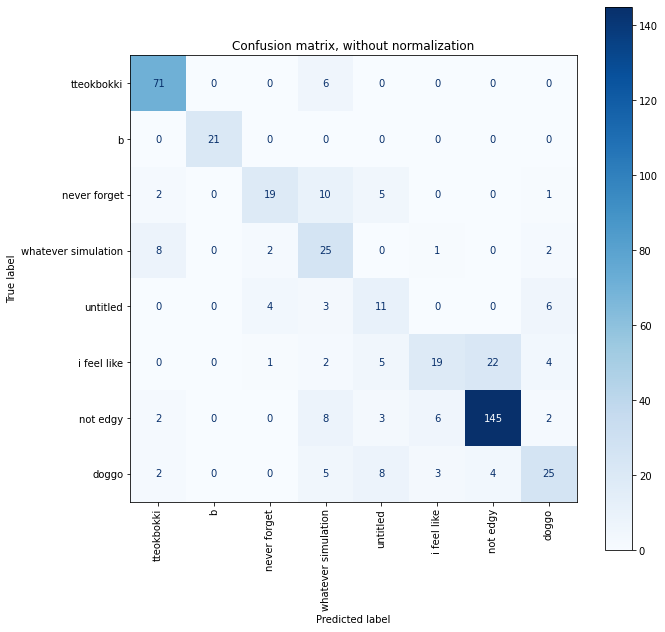

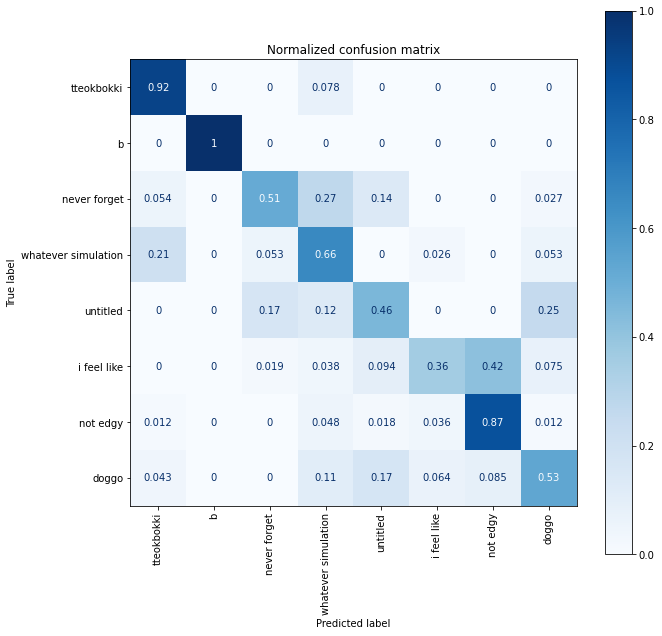

In [10]:
# visualize confusion matrix
titles_options = [
    ('Confusion matrix, without normalization', None),
    ('Normalized confusion matrix', 'true'),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        pred_labels_test,
        labels=names,
        xticks_rotation='vertical',
        normalize=normalize,
        cmap=plt.cm.Blues,
        ax=ax)
    disp.ax_.set_title(title)
plt.show()

#### Evaluating Model Performance

We notice that the model is most accurate when categorizing songs for playlists '[tteokbokki](https://open.spotify.com/playlist/5EJJgEGKlNOFyPKDMzW9W6)', '[b](https://open.spotify.com/playlist/1CC50bbyEzbK4XNqLeRUo2)', and '[not edgy](https://open.spotify.com/playlist/1g5zPlCoUV6dZfj5wdMgNy)'. These playlists are very distinct in that the tracks within them are all more or less of the same genres and artists. On the contrary, the model performs its poorest when attempting to categorize songs into the '[untitled](https://open.spotify.com/playlist/0ur6GzNfyA6kAIqFKC5Zlr)' and '[i feel like](https://open.spotify.com/playlist/7D7XMbpAoyhWD8LFIuwqSS)' playlists. These playlists may be too broad and varied in terms of the genres and sounds of the tracks contained within them, making it tricky to categorize. In addition, in the case of 'i feel like', we can see that the model makes most of its inaccurate predictions towards the playlist 'not edgy', owing to the fact that the two playlists are very similar in genre and sound.